# Лабораторная №6. Audio

В этом лабораторной работе мы будем обрабатывать наш датасет, исследовать его, а также обучать модели для классификации жанров аудио.

- В конфигурации настраиваются:


## Импорты

In [61]:
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from itertools import chain
from collections import Counter
from torch.utils.tensorboard import SummaryWriter

In [62]:
import librosa

In [63]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [64]:
import torch
import torchaudio
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Конфиги

In [65]:
DATASET_PATH = "../data/result_dir" # Путь к папке с данными
TEST_DATASET = "../data/"  # Путь к файлу с тестовыми данными (урезанные данные)

LOG_DIR = "../logs/tensorboard2/"  

DEBUG = True
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
LSTM_MODEL = "genre_model"
RESULTS_DIR = "../result/"  # Путь для папки обработанных данных
MODEL_PATH = "../result/models/"  # Путь к сохраненной модели

In [66]:
SAMPLE_RATE = 22050
N_MFCC = 20
DURATION = 10

In [67]:
# Параметры модели
EPOCHS = 40
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EMBED_DIM = 64
HIDDEN_DIM = 128
OUTPUT_DIM = 5
DROPOUT = 0.6

## Утилиты и функции

In [68]:
def collect_audio_files(dataset_path):
    audio_paths, labels, track_ids = [], [], []
    for genre in os.listdir(dataset_path):
        genre_path = os.path.join(dataset_path, genre)
        if os.path.isdir(genre_path):
            for file_name in os.listdir(genre_path):
                if file_name.endswith('.mp3'):
                    audio_paths.append(os.path.join(genre_path, file_name))
                    labels.append(genre)
                    track_ids.append(file_name)
    return audio_paths, labels, track_ids

In [69]:
def preprocess_audio_save_mfcc(audio_paths, labels, track_ids, target_sr=SAMPLE_RATE, n_mfcc=N_MFCC, duration=DURATION, use_full_song=True):
    mfcc_list = []
    label_list = []
    track_id_list = []
    for path, label, track_id in tqdm(zip(audio_paths, labels, track_ids), total=len(audio_paths), desc="Обработка аудио файлов"):
        y, sr = librosa.load(path, sr=None, mono=True)
        y = librosa.util.normalize(y)
        
        if sr != target_sr:
            y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
        
        if use_full_song:
            total_samples = len(y)
            start_sample = target_sr * 10
            end_sample = total_samples - target_sr * 10
            segments = range(start_sample, end_sample, target_sr * duration)
            
            for start in segments:
                end = start + target_sr * duration
                segment = y[start:end]
                if len(segment) != target_sr * duration:
                    continue
                mfcc = librosa.feature.mfcc(y=segment, sr=target_sr, n_mfcc=n_mfcc)
                mfcc_list.append(mfcc)
                label_list.append(label)
                track_id_list.append(track_id)
        else:
            start_sample = len(y) // 2 - target_sr * duration // 2
            end_sample = start_sample + target_sr * duration
            y = y[start_sample:end_sample]
            mfcc = librosa.feature.mfcc(y=y, sr=target_sr, n_mfcc=n_mfcc)
            mfcc_list.append(mfcc)
            label_list.append(label)
            track_id_list.append(track_id)
        
        print(f"MFCC shape: {mfcc.shape}, {path}")
        
    file_path = os.path.join(os.path.abspath(''), RESULTS_DIR, 'data/mfcc_data.npy')
    np.save(file_path, {'mfccs': np.array(mfcc_list, dtype=object), 'labels': np.array(label_list), 'track_ids': np.array(track_id_list)})
    print(f"MFCC данные сохранены в {RESULTS_DIR}")


Проверим наши данные

In [70]:
def plot_spectrograms(audio_paths, labels, track_ids, sr=SAMPLE_RATE, duration=DURATION):
    genre_examples = {}
    genres = sorted(set(labels))
    num_genres = len(genres)
    
    fig, axes = plt.subplots(num_genres, 2, figsize=(15, 5 * num_genres))
    
    if num_genres == 1:
        axes = np.expand_dims(axes, axis=0) 
    
    cnt = 0
    for path, label, track_id in zip(audio_paths, labels, track_ids):
        cnt += 1
        if label not in genre_examples and cnt >= 2:
            y, _ = librosa.load(path, sr=sr, mono=True)
            total_samples = len(y)
            target_samples = sr * duration
            start_sample = max(0, total_samples // 2 - target_samples // 2)
            end_sample = start_sample + target_samples
            y = y[start_sample:end_sample]
            y = librosa.util.normalize(y)
    
            genre_idx = genres.index(label)
    
            S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
            S_dB = librosa.power_to_db(S, ref=np.max)
    
            ax_spect = axes[genre_idx, 0]
            img1 = librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', ax=ax_spect)
            ax_spect.set_title(f"Spectrogram: {label} (Track ID: {track_id})")
            fig.colorbar(img1, ax=ax_spect, format='%+2.0f dB')
    
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    
            ax_mfcc = axes[genre_idx, 1]
            img2 = librosa.display.specshow(mfcc, x_axis='time', sr=sr, ax=ax_mfcc)
            ax_mfcc.set_title(f"MFCC: {label} (Track ID: {track_id})")
            fig.colorbar(img2, ax=ax_mfcc)
    
            genre_examples[label] = True

            cnt = 0

            # Завершаем, если все жанры обработаны
            if len(genre_examples) == num_genres:
                break
    
    plt.tight_layout()
    plt.show()

In [71]:
def plot_duration_distribution(audio_paths):
    durations = [librosa.get_duration(filename=path) for path in audio_paths]
    plt.figure(figsize=(10, 6))
    plt.hist(durations, bins=30, edgecolor='black')
    plt.title("Распределение длительностей аудио")
    plt.xlabel("Длительность (секунды)")
    plt.ylabel("Количество файлов")
    plt.show()

    return [audio_paths, durations]

In [72]:
def plot_label_distribution(labels):
    label_counts = Counter(labels)
    plt.figure(figsize=(10, 6))
    plt.bar(label_counts.keys(), label_counts.values())
    plt.title("Распределение аудио-жанров")
    plt.xlabel("Жанр")
    plt.ylabel("Количество файлов")
    plt.xticks(rotation=45)
    plt.show()


In [73]:
def load_npy_data(filepath):
    """Load data from an npy file."""
    data = np.load(filepath, allow_pickle=True).item()
    return np.array(data['mfccs'], dtype=np.float32), data['labels'], data['track_ids']
    # return data['mfccs'], data['labels'], data['track_ids']

## 1. **Сбор и подготовка данных:**
   - Я собрал датасет, содержащий музыкальные треки различных жанров (шансон, рок, поп, джаз, классика). Данные собирал с сайта Zaycev.net и включает на момент тестовой выборки 70 песен на жанр.
   - Парсер позволяет собирать данные с сайта Zaycev.net, а также сохранять их в формате json, параметризируя количество песен и жанры.


In [75]:
# тут будет парсер, сейчас он в parse.py, чтобы не захламлять основной код

Рассмотрим пример одной из песен

In [76]:
file_path = os.path.join(DATASET_PATH, 'rap', '4538893.mp3')
waveform, sample_rate = librosa.load(file_path)

In [77]:
waveform, sample_rate

(array([ 6.7392421e-09, -4.9976734e-10,  2.1721007e-08, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32),
 22050)

Видимо нашу песню на графике

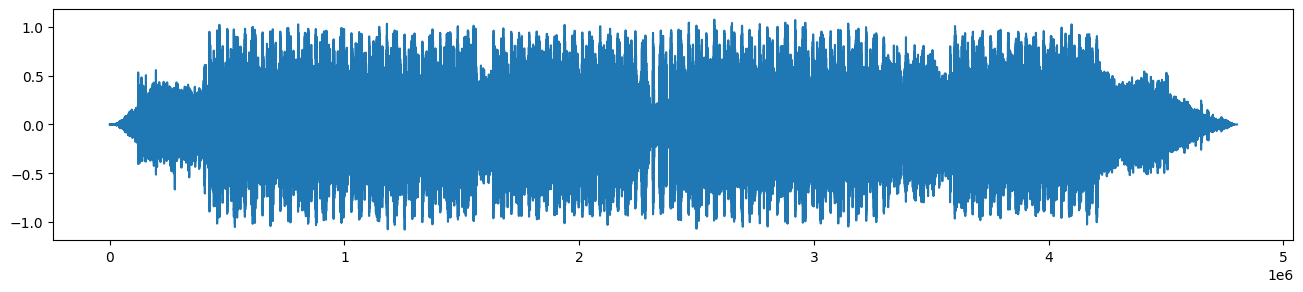

In [78]:
plt.figure(figsize=(16, 3))
plt.plot(waveform)
plt.show()

Посмотрим спектрограмму

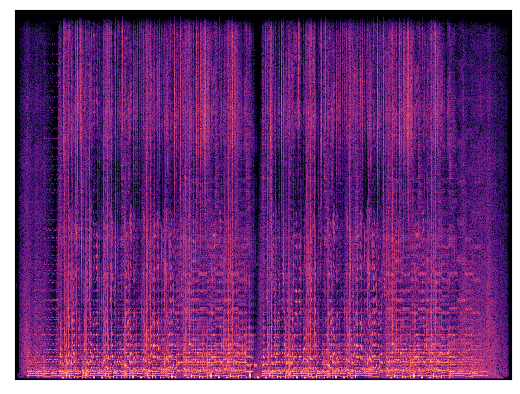

In [79]:
D = librosa.stft(waveform)
db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
librosa.display.specshow(db)

Также посмотрим на спектрограмму фурье преобразований

C:\Users\Username\AppData\Local\Temp\ipykernel_15228\1012855614.py:1: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  librosa.display.specshow(np.log1p(D))


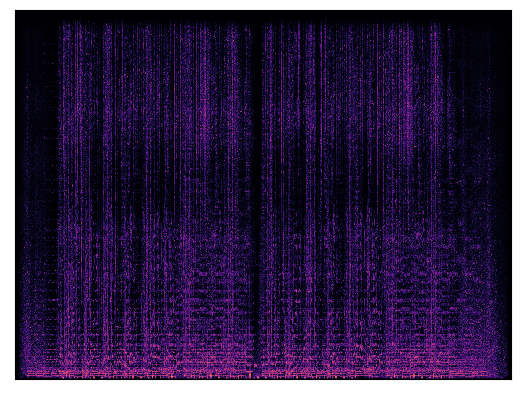

In [80]:
librosa.display.specshow(np.log1p(D))

Построим для отрывка песни график мел-кепстральных коэффициентов

torch.Size([40, 221])


c:\Users\Username\AppData\Local\Programs\Python\Python39\lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


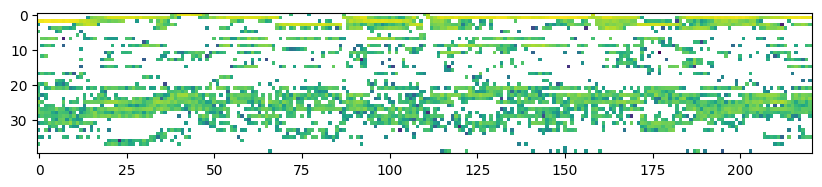

In [81]:
mel_transform = torchaudio.transforms.MFCC()
waveform2 = waveform[30*sample_rate:32 * sample_rate]
mels = mel_transform(torch.Tensor(waveform2)).log2()
print(mels.size())

plt.figure(figsize=(10, 20))
plt.imshow(mels)

In [82]:
# !chcp 65001 > nul && tree ../

## 2. **Предобработка текста:**
   - Конвертация в моно-формат: Все записи были преобразованы в монофонический формат для унификации.
   - Частота дискретизации: Нормализуем частоту дискретизации, установив её на 22,050 Гц.
   - Извлечение MFCC: Использовал библиотеку librosa, чтобы извлечь мел-кепстральные коэффициенты (MFCC) из каждой записи. Это позволит преобразовать аудио в числовые последовательности, которые подходят для обработки LSTM.
   - Сохранение обработанных данных MFCC в формате .npy, чтобы не повторять обработку при каждом запуске.



In [83]:
# audio_paths, labels = collect_audio_files(dataset_path=DATASET_PATH)
# preprocess_audio_save_mfcc(audio_paths, labels)

In [84]:
audio_paths, labels, track_ids = collect_audio_files(DATASET_PATH)
print(f"Собрано {len(audio_paths)} аудиофайлов.")

Собрано 1115 аудиофайлов.


C:\Users\Username\AppData\Local\Temp\ipykernel_15228\115920909.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  durations = [librosa.get_duration(filename=path) for path in audio_paths]


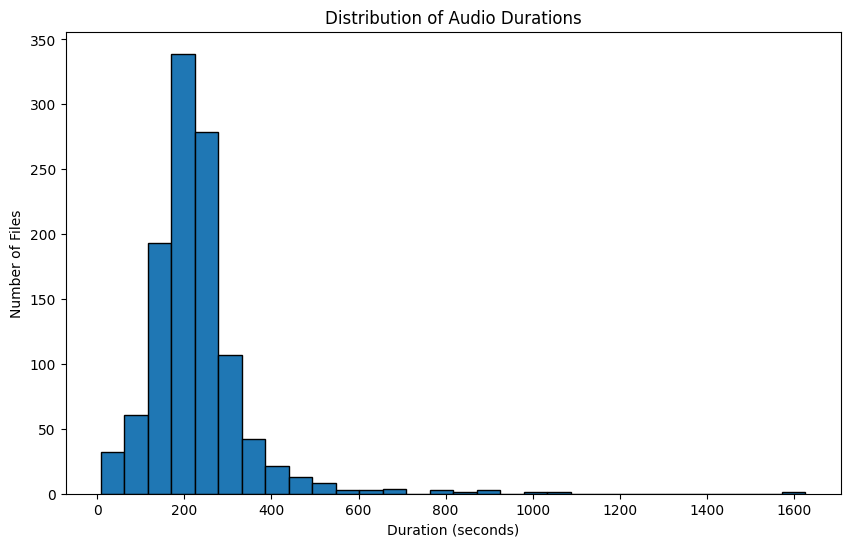

In [85]:
paths_durations = plot_duration_distribution(audio_paths)

Видим странные короткие песни, посмотрим, что там

In [86]:
print(*[x + ' ' + str(y) + '\n' for x, y in zip(paths_durations[0], paths_durations[1])  if y <= 50])

../data/result_dir\classical\24834196.mp3 23.2
 ../data/result_dir\classical\24905038.mp3 48.13897959183674
 ../data/result_dir\classical\25028604.mp3 9.5
 ../data/result_dir\electronic\24871677.mp3 29.454557823129253
 ../data/result_dir\electronic\24916608.mp3 29.454557823129253
 ../data/result_dir\electronic\24921081.mp3 29.454557823129253
 ../data/result_dir\electronic\24952768.mp3 29.454557823129253
 ../data/result_dir\electronic\24996470.mp3 29.454557823129253
 ../data/result_dir\electronic\24996478.mp3 29.454557823129253
 ../data/result_dir\electronic\24999309.mp3 29.454557823129253
 ../data/result_dir\electronic\25002051.mp3 29.454580498866214
 ../data/result_dir\electronic\25028604.mp3 9.5
 ../data/result_dir\electronic\25028609.mp3 10.0
 ../data/result_dir\electronic\25028617.mp3 12.87498866213152
 ../data/result_dir\electronic\25028618.mp3 8.0
 ../data/result_dir\jazz\25028598.mp3 8.5
 ../data/result_dir\jazz\25028602.mp3 16.0
 ../data/result_dir\jazz\25028617.mp3 12.87498866

Итак, мы имеем много пеен короткой длины, это странно, но проверив эти файлы, сразу стало понятно, что это короткие файлы с рекламой, которые не несут в себе никакой информации о жанре. Поэтому я решил удалить их из датасета.

In [87]:
combined = zip(audio_paths, labels, track_ids)
filtered = filter(lambda x: librosa.get_duration(filename=x[0]) >= 20, combined)
audio_paths, labels, track_ids = map(list, zip(*filtered))

C:\Users\Username\AppData\Local\Temp\ipykernel_15228\2939272542.py:2: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  filtered = filter(lambda x: librosa.get_duration(filename=x[0]) >= 20, combined)


Проверим распределение теперь

C:\Users\Username\AppData\Local\Temp\ipykernel_15228\115920909.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  durations = [librosa.get_duration(filename=path) for path in audio_paths]


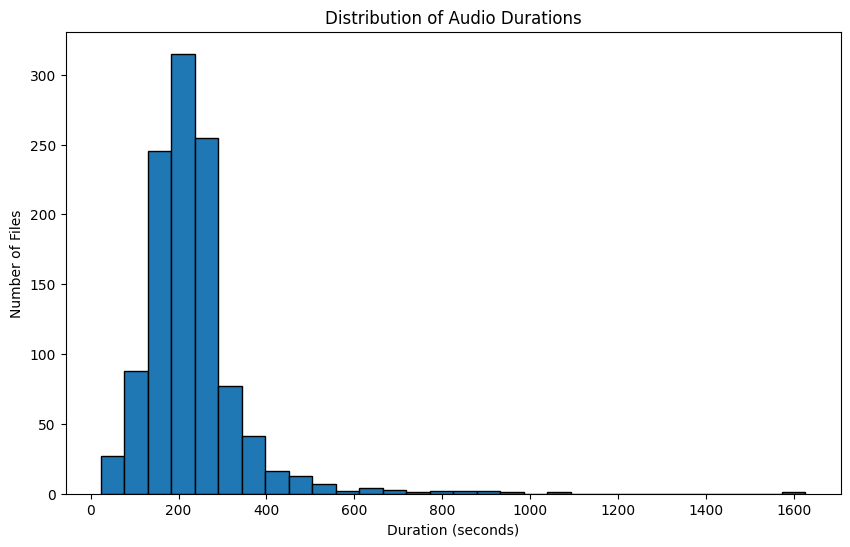

In [88]:
paths_durations = plot_duration_distribution(audio_paths)

In [89]:
print(*[x + ' ' + str(y) + '\n' for x, y in zip(paths_durations[0], paths_durations[1])  if y <= 50])

../data/result_dir\classical\24834196.mp3 23.2
 ../data/result_dir\classical\24905038.mp3 48.13897959183674
 ../data/result_dir\electronic\24871677.mp3 29.454557823129253
 ../data/result_dir\electronic\24916608.mp3 29.454557823129253
 ../data/result_dir\electronic\24921081.mp3 29.454557823129253
 ../data/result_dir\electronic\24952768.mp3 29.454557823129253
 ../data/result_dir\electronic\24996470.mp3 29.454557823129253
 ../data/result_dir\electronic\24996478.mp3 29.454557823129253
 ../data/result_dir\electronic\24999309.mp3 29.454557823129253
 ../data/result_dir\electronic\25002051.mp3 29.454580498866214
 ../data/result_dir\rap\24915336.mp3 36.36244897959184
 ../data/result_dir\rap\24999309.mp3 29.454557823129253
 ../data/result_dir\rap\25002051.mp3 29.454580498866214
 ../data/result_dir\rap\25002076.mp3 29.454557823129253
 ../data/result_dir\shanson\24770179.mp3 34.97451247165533
 ../data/result_dir\shanson\24816373.mp3 35.84



Все оставшиеся несут в себе информацию о жанре, поэтому мы можем продолжить обработку данных.


## 3. **Разметка датасета:**
   - Убедимся, что данные сбалансированы

Начнем с распределения по классам

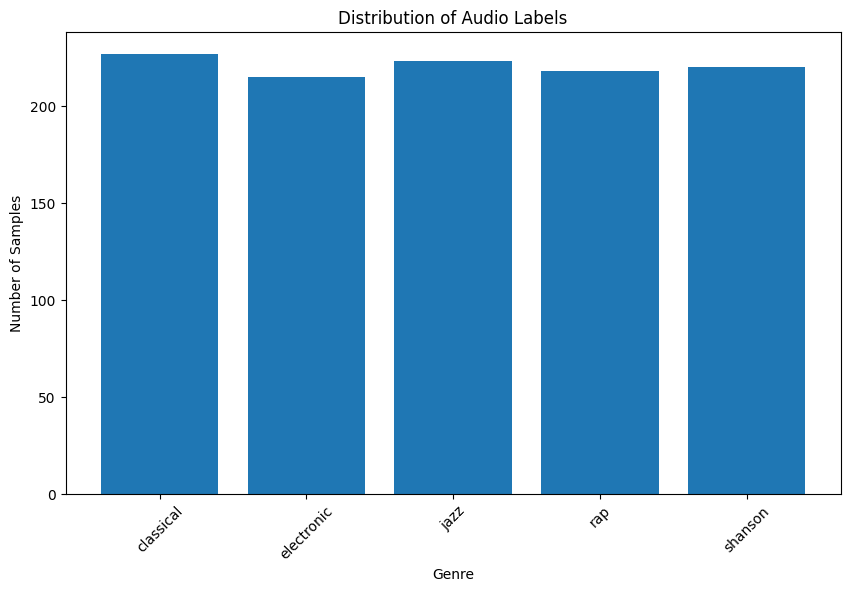

In [90]:
plot_label_distribution(labels)

Мы видим равномерное распределение мелодий по жанрам, значит дисбаланса никакого нет, благодаря парсеру все довольно ровно, а количество нейтрализовало влияние удаления рекламы.

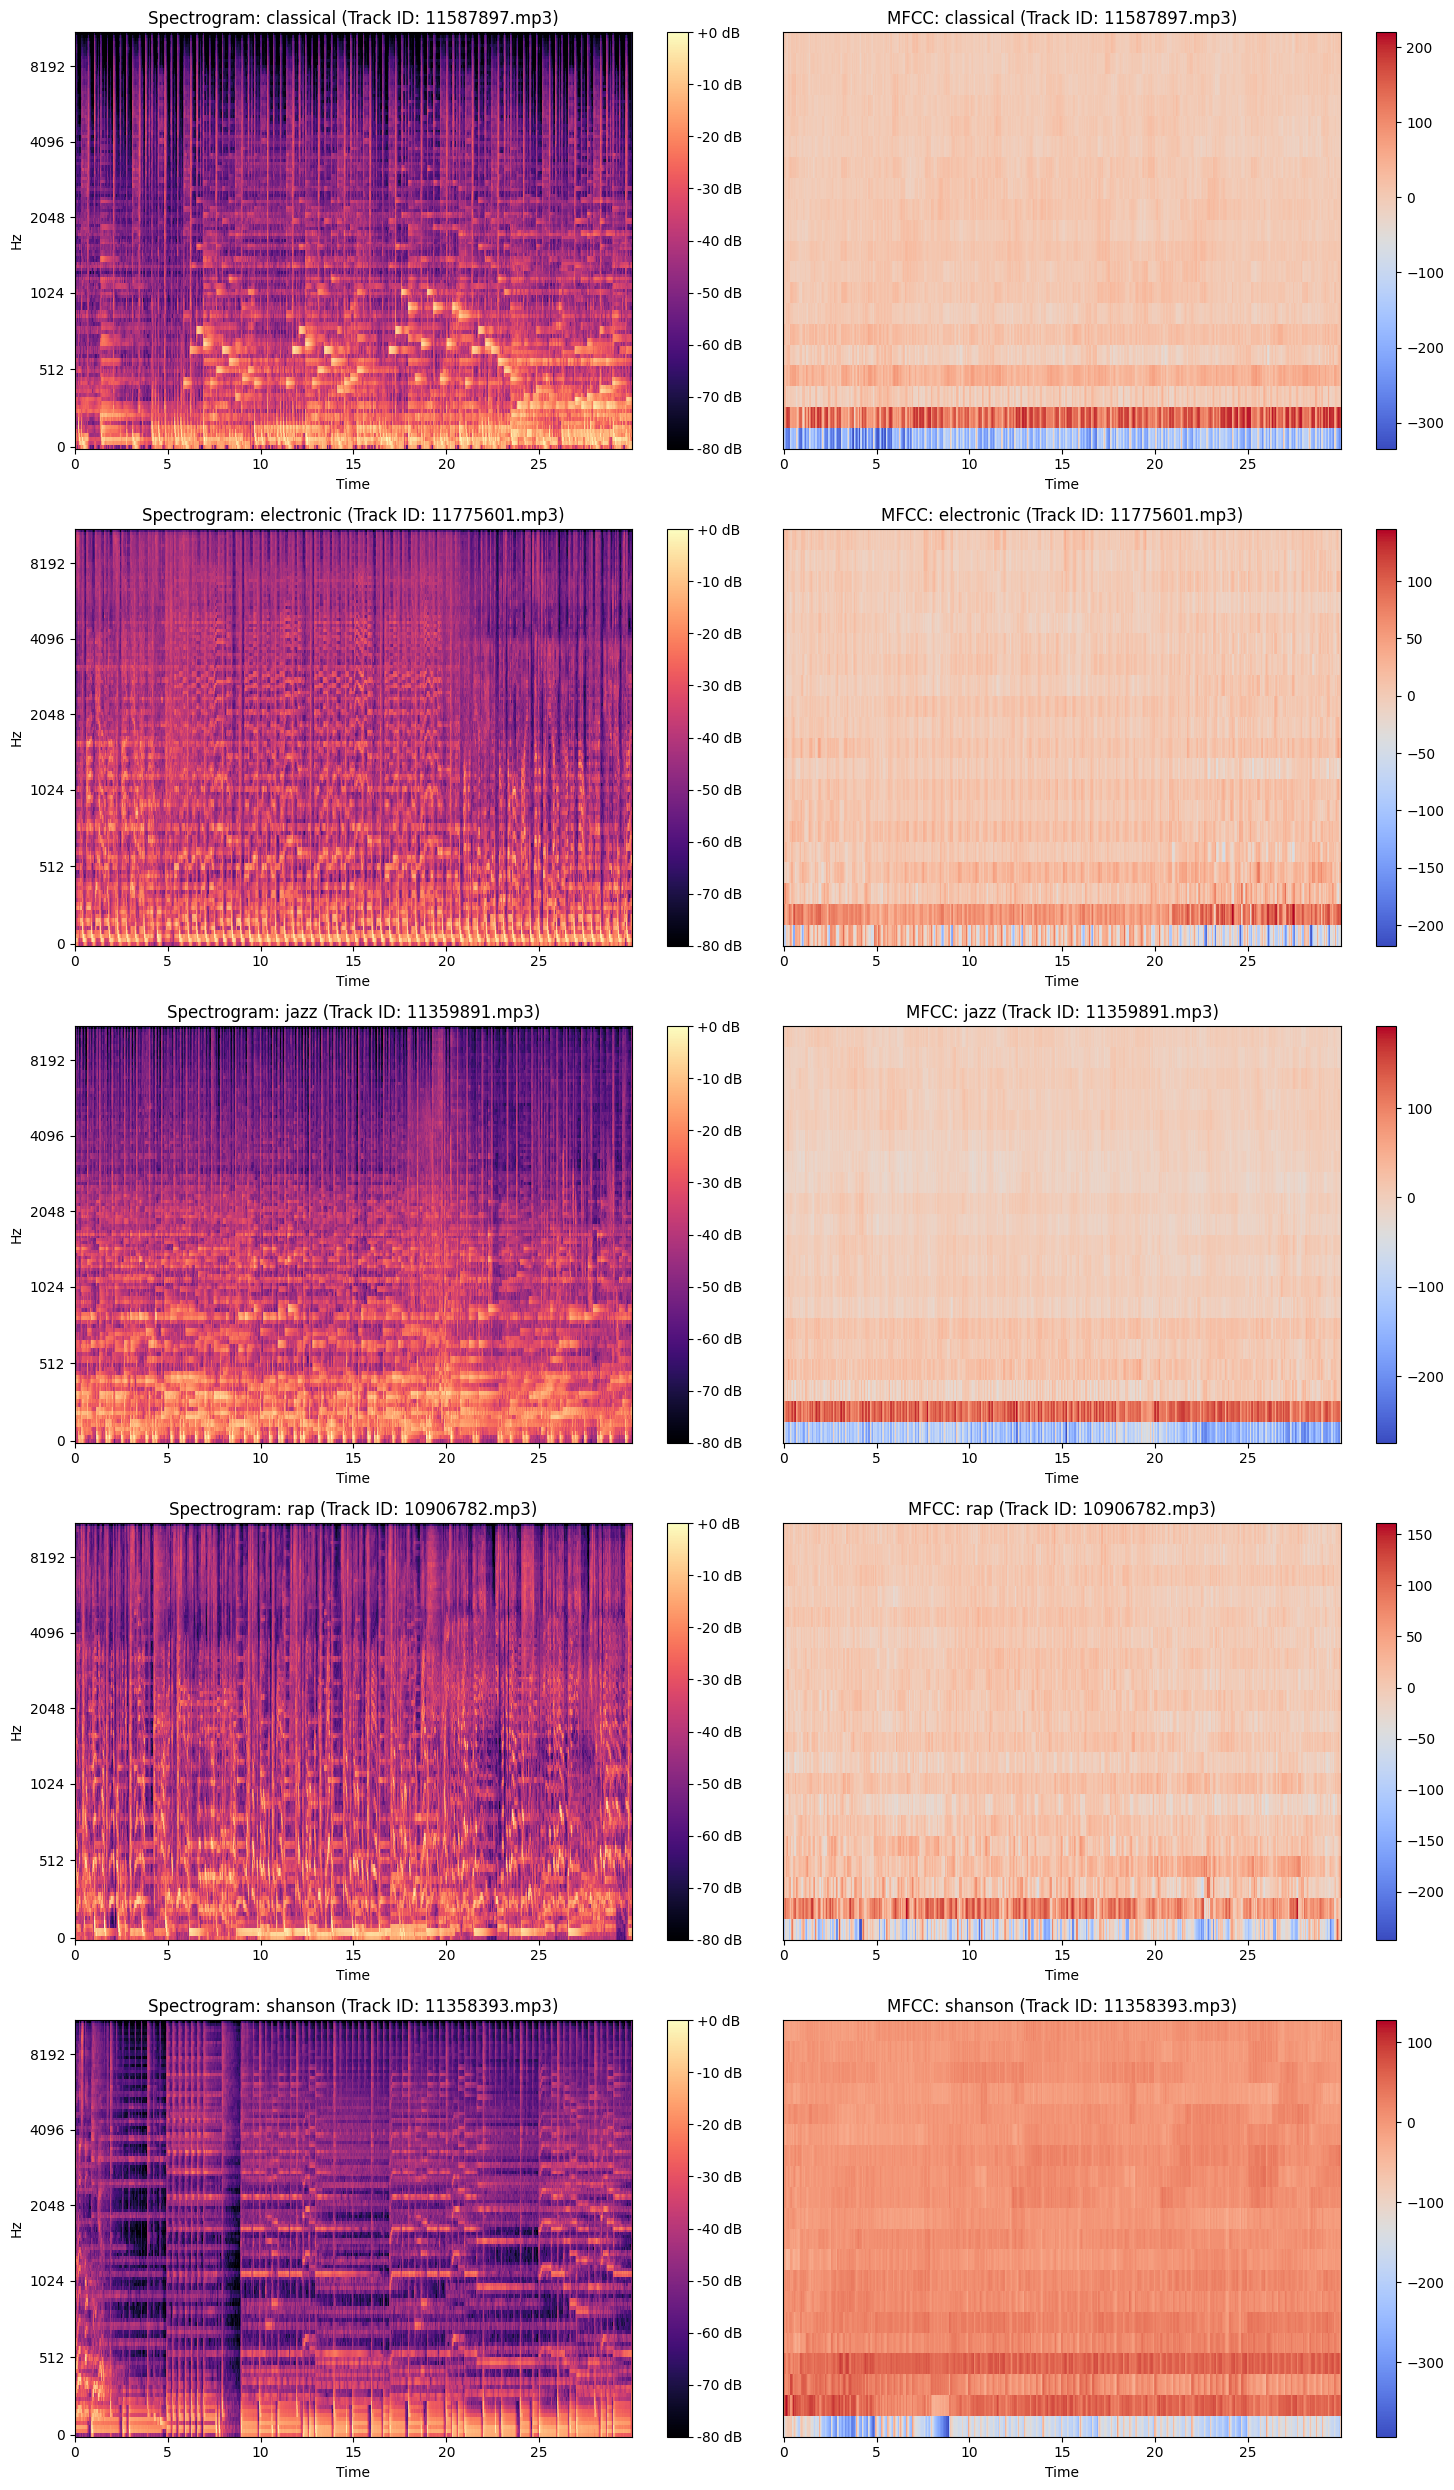

In [91]:
plot_spectrograms(audio_paths, labels, track_ids, duration=30)

Посмотрим на наши графики, были рандомно выбраны по треку из каждого жанра.

- Классика:
    Видно значительное присутствие низких частот (до 512 Гц) на протяжении всего трека, судя по всему это связано с использованием басовых инструментов (например, контрабаса или виолончели) в классической композиции.
    Высокие частоты также присутствуют, но они менее выражены по сравнению с другими жанрами, думаю это из-за отсутствия вокальной линии.
- Электронная музыка
    Здесь низкие частоты тоже выражены, но с более сильной регулярностью (например, повторяющийся басовый удар).
    Однако по сравнению с классической музыкой они кажутся менее плотными и более "пульсирующими".
- Джаз
    Низкие частоты хорошо заметны, но в меньшей степени, чем у классической музыки.
    Видно, что уделено внимание средним и высоким частотам, отражающим работу духовых инструментов.
- Рэп
    Здесь низкие частоты особенно акцентированы и стабильны (характерно для бита), но они меньше варьируются по времени, чем в классической музыке или электронной.
    Видновокальные части музыки
- Шансон
    Низкие частоты присутствуют, но их уровень кажется менее насыщенным, чем в классической или рэп-музыке.

После всех обработок выполним подготовку датасета

На этом этапе я столкнулся с тем, что аудиофайлов нагружено на 15гигов, а брал я duration=10 секундам, наверное это нерационально иметь такой датасет огромный и брать только 5%, поэтому я решил добавить возможность делить каждую песню на отрывки длиной 10 секунд, получаетсяя одна песня производит много коротких отрывков, отступая по 10 секунд от начала и конца(т.к. обычно там нехарактерные мелодии для жанра, вступления и завязки). Ну и еще одна причина, по которой я это сделал - низкая точность на валидационной выборке, но я заметил, что с увеличением датасета ситуация улучшается.

In [92]:
if DEBUG or not os.path.exists(os.path.join(os.path.abspath(''), RESULTS_DIR, 'data/mfcc_data.npy')):
    preprocess_audio_save_mfcc(audio_paths, labels, track_ids)

MFCC shape: (20, 431), ../data/result_dir\classical\11587820.mp3
MFCC shape: (20, 431), ../data/result_dir\classical\11587897.mp3
MFCC shape: (20, 431), ../data/result_dir\classical\11588098.mp3
MFCC shape: (20, 431), ../data/result_dir\classical\11589263.mp3
MFCC shape: (20, 431), ../data/result_dir\classical\11590009.mp3
MFCC shape: (20, 431), ../data/result_dir\classical\11881967.mp3
MFCC shape: (20, 431), ../data/result_dir\classical\11882077.mp3
MFCC shape: (20, 431), ../data/result_dir\classical\11884133.mp3
MFCC shape: (20, 431), ../data/result_dir\classical\11884203.mp3
MFCC shape: (20, 431), ../data/result_dir\classical\11884543.mp3
MFCC shape: (20, 431), ../data/result_dir\classical\11885483.mp3
MFCC shape: (20, 431), ../data/result_dir\classical\11940230.mp3
MFCC shape: (20, 431), ../data/result_dir\classical\11940231.mp3
MFCC shape: (20, 431), ../data/result_dir\classical\11940304.mp3
MFCC shape: (20, 431), ../data/result_dir\classical\11940410.mp3
MFCC shape: (20, 431), ..

In [93]:
file_path = os.path.join(os.path.abspath(''), RESULTS_DIR, 'data/mfcc_data.npy')

mfccs, labels, track_ids = load_npy_data(file_path)

print(f"MFCCs shape: {mfccs.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Track IDs shape: {track_ids.shape}")

MFCCs shape: (23691, 20, 431)
Labels shape: (23691,)
Track IDs shape: (23691,)



## 4. **Модель:**
   - Архитектура LSTM:
   - Входной слой принимает последовательности MFCC.
   - Функция потерь: CrossEntropyLoss для многоклассовой классификации.
   - Оптимизатор: Adam.
   - Контроль переобучения: Dropout
   - Данные разделим на тренировочную, валидационную и тестовую выборки (70 - 15 - 15)

In [118]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.0):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True, dropout=dropout)
        self.batch_norm = nn.BatchNorm1d(hidden_dim * 2)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        batch_out = self.batch_norm(lstm_out[:, -1, :])
        drop_out = self.dropout(batch_out)
        out = self.fc(drop_out)
        return out, drop_out

In [95]:
class AudioDataset(Dataset):
    def __init__(self, mfccs, labels, transform=None):
        self.label_to_idx = {label: idx for idx, label in enumerate(sorted(set(labels)))}
        self.mfccs = torch.tensor(mfccs)
        self.labels = torch.tensor([self.label_to_idx[label] for label in labels])
        self.transform = transform

    def __len__(self):
        return len(self.mfccs)

    def __getitem__(self, idx):
        mfcc = self.mfccs[idx]
        mfcc = mfcc.T
        label = self.labels[idx]
        if self.transform:
            mfcc = self.transform(mfcc)
        return mfcc, label

In [96]:
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15

In [97]:
full_dataset = AudioDataset(mfccs, labels)

train_size = int(TRAIN_RATIO * len(full_dataset))
val_size = int(VAL_RATIO * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

In [98]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Проверяем размерности датасетов

In [99]:
print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}")

Train size: 16583, Validation size: 3553, Test size: 3555


In [100]:
import numpy as np

all_mfccs = [train_dataset[i][0] for i in range(len(train_dataset))]
unique_shapes = np.unique([mfcc.shape for mfcc in all_mfccs], axis=0)

print(f"Unique MFCC shapes: {unique_shapes}")

Unique MFCC shapes: [[431  20]]



## 5. **Обучение модели:**
   - Обучим модель на размеченных данных. В качестве оценки задействуем такие метрики, такие как **loass**, **accuracy**. И отобразим их на графиках


In [136]:
# DEVICE = torch.device("cpu")
model = LSTMModel(input_dim=N_MFCC, hidden_dim=HIDDEN_DIM, output_dim=OUTPUT_DIM, dropout=DROPOUT).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

c:\Users\Username\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn(


In [137]:
# Определение пути для логов
log_dir = os.path.join(os.path.abspath('').replace('Документы', 'Documents'), LOG_DIR)

# log_dir = 'd://Users/Username/OneDrive - ITMO UNIVERSITY/Documents/Itmo/5sem/MachineLearning/Labs/audio-GameTrue/src/zaycev/logs/tensorboard2/'

os.makedirs(log_dir, exist_ok=True)

# if os.path.isdir(log_dir):
#     print(f"Директория {log_dir} существует.")
# else:
#     print(f"Не удалось создать директорию {log_dir}.")


writer = SummaryWriter(log_dir=log_dir)

In [138]:
def train_epoch(model, loader, criterion, optimizer, device, epoch):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for inputs, labels in loader:
        # print(torch.unique(labels))
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, _ = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return total_loss / total, correct / total

# Функция валидации

def validate_epoch(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, _ = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return total_loss / total, correct / total

In [ ]:
# DEVICE = torch.device("cpu")
best_val = 0
for epoch in tqdm(range(EPOCHS), desc="Обучение модели", maxinterval=200):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE, epoch)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, DEVICE)

    writer.add_scalars('Loss', { 'train':  train_loss, 'val': val_loss}, epoch)
    writer.add_scalars('Accuracy', { 'train':  train_acc, 'val': val_acc}, epoch)

    if val_acc > best_val:
        torch.save(model.state_dict(), os.path.join(os.path.abspath(''), MODEL_PATH, f"best_{LSTM_MODEL}.pth"))

    print(f"Epoch {epoch+1}/{EPOCHS}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

writer.flush()

In [105]:
# Сохранение модели
torch.save(model.state_dict(), os.path.join(os.path.abspath(''), MODEL_PATH, f"{LSTM_MODEL}.pth"))
print("Model saved.")

Model saved.


In [106]:

writer.close()


## 6. **Оценка модели:**
   - Протестируем модель на тестовом наборе и сравним метрики на train и test.
   -  В качестве оценки задействуем такие метрики, такие как **accuracy**, **precision**, **recall**, **F1 score** для оценки качества.


In [149]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model = LSTMModel(input_dim=N_MFCC, hidden_dim=HIDDEN_DIM, output_dim=OUTPUT_DIM, dropout=DROPOUT).to(DEVICE)
model.load_state_dict(torch.load(os.path.join(os.path.abspath(''), MODEL_PATH, f"{LSTM_MODEL}.pth")))

all_labels = []
all_preds = []
all_embeddings = []

def evaluate_model(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, embeding = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_embeddings.extend(embeding.cpu().numpy())
    accuracy = correct / total
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    matrix = confusion_matrix(all_labels, all_preds)
    return total_loss / total, accuracy, precision, recall, f1, matrix

test_loss, test_acc, test_precision, test_recall, test_f1, matrix = evaluate_model(model, test_loader, criterion, DEVICE)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

c:\Users\Username\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn(


Test Loss: 0.7830
Test Accuracy: 0.7193
Test Precision: 0.7185
Test Recall: 0.7193
Test F1 Score: 0.7159


In [150]:
print("Матрица ошибок:")
print(matrix)

Матрица ошибок:
[[697  26  93   6  39]
 [ 34 289  97  99  70]
 [ 85  43 559  45  57]
 [ 19  62  48 428  50]
 [ 12  17  68  28 584]]


Визуализируем

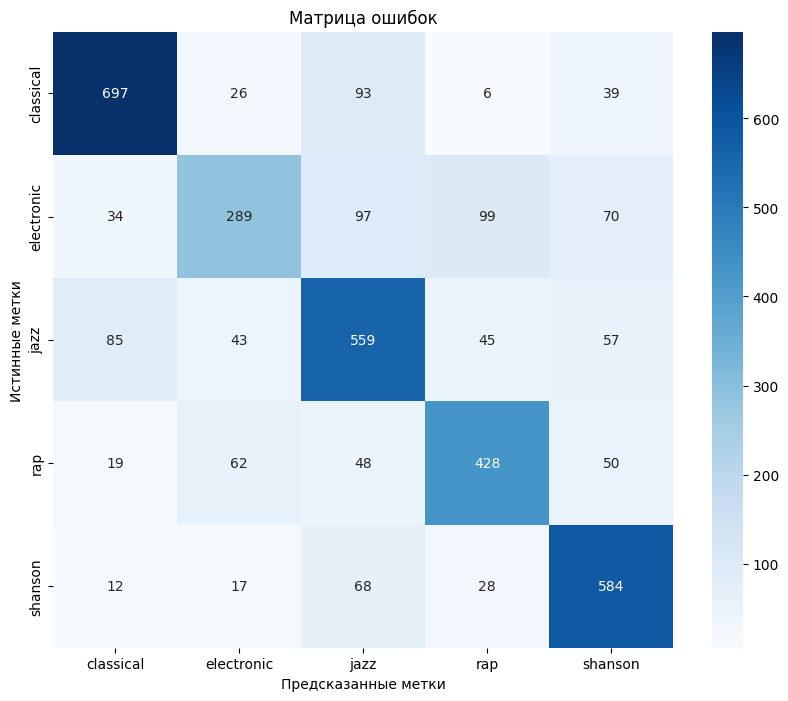

In [151]:
import seaborn as sns

class_names = {idx: label for idx, label in enumerate(sorted(set(labels)))}
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names.values(), yticklabels=class_names.values())
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title('Матрица ошибок')
plt.show()

Что можно увидеть: модель хорошо справляется с классами classical, jazz и shanson, правильно классифицируя большинство треков.
Жанры electronic и rap вызывают наибольшее количество ошибок, оно и понятно, ведь по графикам они будут очень похожи в своей ритмичности
 - Classical чаще путается с Jazz и Shanson.
 - Electronic часто путается с Jazz, Rap и Shanson.
 - Rap путается с Electronic и Shanson.
 - Jazz путается с Classical и Shanson.
 - Shanson путается с Jazz и Rap.

![accuracy](./image.png)
![Loss](./image2.png)

На графике метрик видно, что переобучение отсутсвует, валидационная выборка также хорошо классифицируется, как и тренировочная. 
На графике идут 2 захода, первый - брать просто 10 секукнд песни из центра, второй - брать по 10 секунд от начала и конца песни, отступая по 10 секунд с каждой стороны, чтобы исключить завязку и заключение песни, которые стали бы шумами, второй вариант показал лучший результат, но и требует больше времени на обработку данных, т.к. одна песня теперь создает много коротких фрагментов по 10 секунд.

В целом, наша модель показывает хорошие результаты, правильно классифицируя примерно 72% случая и эффективно балансируя между точностью и полнотой. Это означает, что модель достаточно надёжна для использования в практике, но всегда есть возможности для её дальнейшего улучшения, если еще увеличить датасет точность распознавания увеличится.

### Визуализзация эмбедингов
   - Для визуализации эмбеддингов используем методы понижение размерности **PCA**, **UMAP**, **t-sne** для отображения аудио в 2D
   - Отметим, какие жанры лучше всего отделяются друг от друга

In [152]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt

In [153]:
all_embedings_array = np.array(all_embeddings)

pca = PCA(n_components=2, random_state=42)
pca_embeddings = pca.fit_transform(all_embedings_array)

In [154]:
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_embeddings = umap_reducer.fit_transform(all_embedings_array)

c:\Users\Username\AppData\Local\Programs\Python\Python39\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [155]:
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(all_embedings_array)

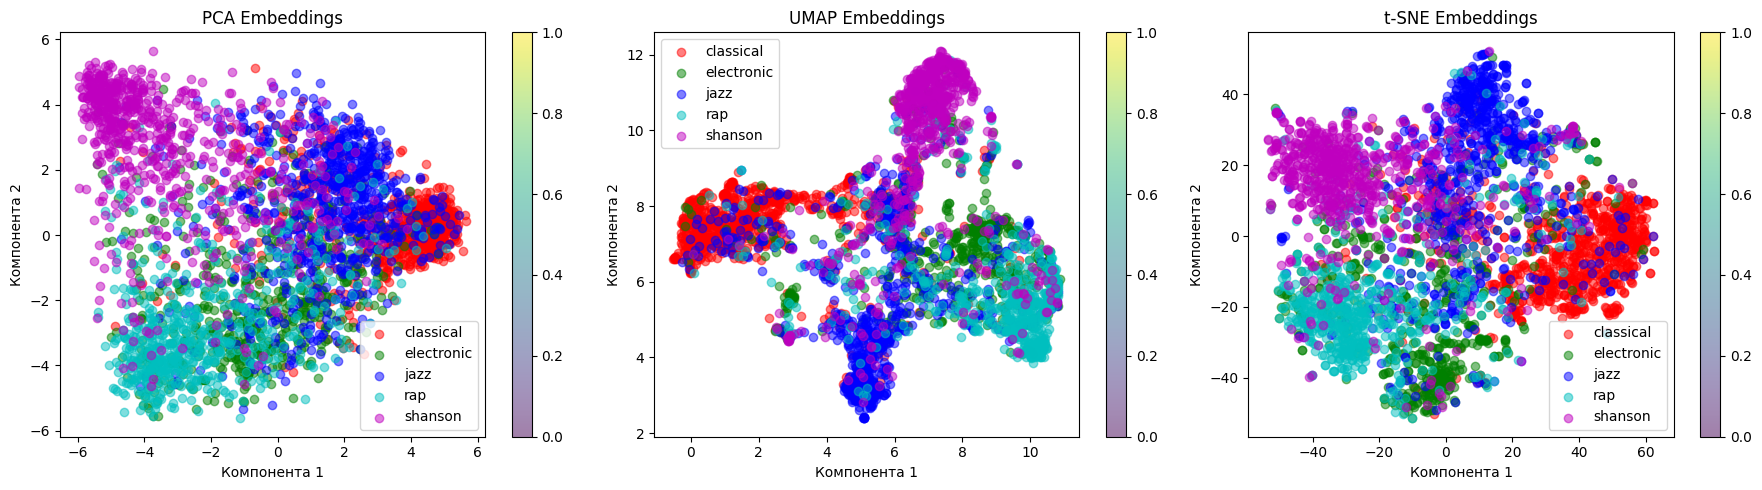

In [156]:
plt.figure(figsize=(18, 5))

# Define colors for each genre
colors = ['r', 'g', 'b', 'c', 'm']
genre_labels = list(class_names.values())

plt.subplot(1, 3, 1)
for i, genre in enumerate(genre_labels):
    idx = [j for j, label in enumerate(all_labels) if label == i]
    plt.scatter(pca_embeddings[idx, 0], pca_embeddings[idx, 1], c=colors[i], label=genre, alpha=0.5)
plt.colorbar()
plt.title('PCA Embeddings')
plt.xlabel('Компонента 1')
plt.ylabel('Компонента 2')
plt.legend()

plt.subplot(1, 3, 2)
for i, genre in enumerate(genre_labels):
    idx = [j for j, label in enumerate(all_labels) if label == i]
    plt.scatter(umap_embeddings[idx, 0], umap_embeddings[idx, 1], c=colors[i], label=genre, alpha=0.5)
plt.colorbar()
plt.title('UMAP Embeddings')
plt.xlabel('Компонента 1')
plt.ylabel('Компонента 2')
plt.legend()

plt.subplot(1, 3, 3)
for i, genre in enumerate(genre_labels):
    idx = [j for j, label in enumerate(all_labels) if label == i]
    plt.scatter(tsne_embeddings[idx, 0], tsne_embeddings[idx, 1], c=colors[i], label=genre, alpha=0.5)
plt.colorbar()
plt.title('t-SNE Embeddings')
plt.xlabel('Компонента 1')
plt.ylabel('Компонента 2')
plt.legend()

plt.tight_layout()
plt.show()

Провизуализировав эмбединги, в целом можем увидеть отдельные кластеры (на t-sne получается пятилистник с шумами и путающимсяя джасом и электронной)

Можно увидеьт, что жанры "classical", "shanson" и "rap" хорошо отделены друг от друга и от остальных жанров. В то же время "electronic", "jazz" имеют пересечения с другими жанрами, что указывает на их схожесть по признакам. t-SNE и UMAP лучше разделяют данные, чем PCA, но пересечения между "rap" и "electronic", а также "jazz" с классикой остаются заметными. Эти пересечения объясняют путаницу в матрице ошибок, особенно между "electronic" и "rap".